# Dr Dennett's Guide to Spatial Interaction Modelling  -  Part 2: Constrained Models 
Code translated to Python by Philip Wilkinson
## Recap

So, last time we learned all about the unconstrained spatial interaction model; how we can use it to estimate flows in a system using values for origin emissiveness or destination attractiveness; how we can tweak the estaimtes the model produces through adjusting either the parameters associated with the predictor variables, or through using different predictor variables or updating their values; and how we can improve the fits of the model further by calibrating the paramaters through using a Poisson regression model.

We saw that even after calibration, our model still only explained around 60% of the variation in the flows that we observed in our system, so can we do any better? Well yes, yes we can!

First of all however, lets bring some of our work across from the previous practical so that we can get straight to it.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import folium
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats
import numpy as np
from math import sqrt

In [2]:
def CalcRSqaured(observed, estimated):
    """Calculate the r^2 from a series of observed and estimated target values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    r, p = scipy.stats.pearsonr(observed, estimated)
    R2 = r **2
    
    return R2

def CalcRMSE(observed, estimated):
    """Calculate Root Mean Square Error between a series of observed and estimated values
    inputs:
    Observed: Series of actual observed values
    estimated: Series of predicted values"""
    
    res = (observed -estimated)**2
    RMSE = round(sqrt(res.mean()), 3)
    
    return RMSE

In [3]:
cdatasub = pd.read_csv("Data/cdatasub1.csv", index_col=0)

# Constrained models

If we return to [Alan Wilson's 1971 paper](https://journals.sagepub.com/doi/abs/10.1068/a030001), he introduces a full <i>family</i> of spatial interaction models of which the unconstrained model is just the start. And indeed since then, there have been all number of incremental advances and alternatives (such as [Stewart Fotheringham's Competing Destinations models](https://www.researchgate.net/publication/23537117_A_New_Set_of_Spatial-Interaction_Models_The_Theory_of_Competing_Destinations), [Pooler's production/attractino/cost relaxed models](http://journals.sagepub.com/doi/abs/10.1177/030913259401800102), [Stillwell's origin/destination parameter specific models](http://journals.sagepub.com/doi/pdf/10.1068/a101187) and [mine and Alan's own multi-level model](http://journals.sagepub.com/doi/pdf/10.1068/a45398) (to name just a few).

In this sessnio we will explore the rest of Wilson's family - the PRoduction (origin) Constrained Model; the Attraction (destination) constrained model; and the Doubly Constrained Model.

We will see how we can, again, use a Poisson regression model in Python to calibrate these models and how, once calibrated, we can use the models in different contexts, such as Land USe Transportatino Interaction (LUTI) modelling, retail modelling and migration modelling,

# 1. Production and Attraction Constrained Models

First of all let extract the results that we got last time:

In [4]:
cdatasubmat = pd.pivot_table(cdatasub, values ="TotalNoIntra", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


Wilson's real contribution to the field was in noticing that the unconstrained gravity model was sub-optimal as it did not make use of all of the available data in the syste, we are studying.

If we recall the estimates from our unconstrained model, none of the estimated summed to the observed in and out-flow totals:

In [5]:
cdatasubmat2 = cdatasub.pivot_table(values ="unconstrainedEst2", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat2

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,206.0,808.0,145.0,294.0,308.0,1264.0,3025
Barnet,1015.0,NaN,968.0,5683.0,919.0,6422.0,9587.0,24594
Bexley,2231.0,542.0,NaN,430.0,2099.0,869.0,3803.0,9974
Brent,591.0,4707.0,636.0,NaN,686.0,4957.0,7034.0,18611
Bromley,1480.0,937.0,3820.0,844.0,NaN,1567.0,6670.0,15318
Camden,623.0,2635.0,637.0,2455.0,630.0,NaN,15056.0,22036
City of London,20.0,32.0,22.0,28.0,22.0,121.0,NaN,245
All,5960.0,9059.0,6891.0,9585.0,4650.0,14244.0,43414.0,93803


Our estimates did sum to the grand total of flows, but this is because we were really fitting a 'total constrained' model which used $k$ - our constant of proportionality -  to esnure everything sort of added up (to within 1 commuter).

Where we have a full flow matrix to calibratte parameters, we can imporate the row (origin) totals, column (destination) totals or both origin and destination totals to <i>constrain</i> our flow estimates to these known values.

There are various reasons for wanting to do this, for example:

1. If we are interested in flows of money into businesses or customers into shops, might have information on the amount of disposable income and shopping habits of the people living in different areas from loyalty card data. This is known information about our origins and so we could constrain our spatial interaction model to this known information - we can make the assumption that this level of disposable income remains the same. We can then use other information about the attractiveness of places these people might like to shop in (store size, variety / specialism of goods etc.), to estimate how much money a new store opening in the area might make, or if a new out-of-town shopping centre opens, how much it might affect the business of shops in the town centre. This is what is known in the literature as the ‘retail model’ and is perhaps the most common example of a <b>Production (orign) Constrained Spatial Interaction Model</b>

2. We might be interested in understanding the impact of a large new employer in an area on the flows of traffic in the vicinity or on the demand for new worker accommodation nearby. A good example of where this might be the case is with large new infrastructure developments like new airports. For example, before the go-ahead for the new third runway at Heathrow was given, one option being considered was a new runway in the Thames Estuary. If a new airport was built here, what would be the potential impact on transport flows in the area and where might workers commute from? This sort of scenario could be tested with an <b>Attraction (destination) Constrained Spatial Interaction Model</b> where the number of new jobs in a destination is known (as well as jobs in the surrounding area) and the model could be used to estimate where the workers will be drawn from (and their likely travel-to-work patterns). This model is exactly the sort of model Land Use Transport Interaction (LUTI) model that was constructed by the Mechanicity Team in CASA - details here if you are interested…

3. We might be interested in understanding the changing patterns of commuting or migration over time. Data from the Census allows us to know an accurate snap-shot of migrating and commuting patterns every 10 years. In these full data matrices, we know both the numbers of commuters/migrants leaving origins and arriving at destinations as well as the interactions between them. If we constrain our model estimates to this known information at origin and destination, we can examine various things, including:
    - The ways that the patterns of commuting/migration differ from the model predictions - where we might get more migrant/commuter flows than we would expect
    - How the model parameters vary over time - for example how does distance / cost of travel affect flows over time? Are people prepared to travel further or less far than before?

# 2. Production-constrained Model


\begin{equation} \label{eq:1} \tag{1}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation} \label{eq:2} \tag{2}
O_i = \sum_j T_{ij}
\end{equation}

and

\begin{equation} \label{eq:3} \tag{3}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

In the production-constrained model, $O_i$ does not have a parameter as it is a known constraint. $A_i$ is known as a <i>balancing factor</i> and is a vector of values which relate to each origin, $i$, which do the equivalent job to $k$ in the unconstrained/total constrained model but ensure that flow estimates from each origin sum to the known totals, $O_i$ rather than just the overall total.

No at this point, we could calculate all of the $O_i$s and $A_i$s by hand for our sample system and then set about guessing/estimating the parameter values for the rest of the model, but as you might have already suspected from last time, we can use Python and `glm` to make it really easy and do all of that for us -woo hoo!

We set about re-specifying the Production Constrained model as a Poisson regression model in exactly the same way as we did before. We need to take logs of the right-hand side of the equation and assume that these are logarithmically linked to the Poisson distributed mean ($\lambda_{ij}$) of the $T_{ij}$ variable. As such, Equation (1) becomes:

\begin{equation} \label{eq:4} \tag{4}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln W_j - \beta \ln d_{ij})
\end{equation}

In Equation (4) $\alpha_i$ is the equivalent of the vector of balancing factors $A_i$, but in regression /log-linear modelling terminology can also be described as either <b>dummy variables</b> or <b>fixed effects</b>/ In practical terms, what this means is that in our regression model, $\mu_i$ is modelled as a [categorical predictor](https://en.wikipedia.org/wiki/Categorical_variable) and therefore in the Poisson regression model, we don't use the numeric values of $O_i$, we can use a categorical identifier for the origin. In terms of the example table above, for Barking and Dagenham we wouldn't use 5675 as we would if we were fitting Equation (1), we would just used 'Barking and Dagenham'.

So, let's give this model a whirl...

In [6]:
#create the formula (the "-1" indicates no intercept in the regression model).
formula = 'Total ~ OrigCodeNew + log_Dj2_destsal + log_Dist-1'
#run a production constrained sim
prodSim = smf.glm(formula = formula, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(prodSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       33
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -14977.
Date:                Fri, 22 Jan 2021   Deviance:                       29640.
Time:                        11:17:52   Pearson chi2:                 2.89e+04
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
OrigCodeNew[E09000001]     4

So, what do we have?

Well, there are the elements of the model output that should be familiar from the unconstrained model:

The $\gamma$ parameter related to the destination attractiveness: 2.0440

The $\beta$ distance decay parameter: -2.2140

We can see from the standard outputs from the model that all of the explanatory variables are statistically significant (P>|z| < 0.01) and the z-scores indicate that the destination salary is having the most influence on the model, with distance following closely behind. And then we have a series of paramaters which are the vector of $\alpha_i$ values associated with our origin constraints.

## 2.1 Model Estimates

Now at this point you will be wanting to know what affect the constraints have had on the estimates produced by the model, so let's plug the parameters back into Equation 4 and take a look...

Create some $O_i$ and $D_j$ columns and store the total in and out flow matrix margins in them. 

In [7]:
#create some Oi and Dj columns in the dataframe and store row and column totals in them:
#to create O_i, take cdatasub ...then... group by origcodenew ...then... summarise by calculating the sum of Total
O_i = pd.DataFrame(cdatasub.groupby(["OrigCodeNew"])["Total"].agg(np.sum))
O_i.rename(columns={"Total":"O_i"}, inplace = True)
cdatasub = cdatasub.merge(O_i, on = "OrigCodeNew", how = "left" )

D_j = pd.DataFrame(cdatasub.groupby(["DestCodeNew"])["Total"].agg(np.sum))
D_j.rename(columns={"Total":"D_j"}, inplace = True)
cdatasub = cdatasub.merge(D_j, on = "DestCodeNew", how = "left" )

Now we want to fish the coefficients out of the prodSim glm object.

In [8]:
#We can do this by pulling out the paramaetr values
coefs = pd.DataFrame(prodSim.params)
coefs.reset_index(inplace=True)
coefs.rename(columns = {0:"alpha_i", "index":"coef"}, inplace = True)
to_repl = ["(OrigCodeNew)", "\[", "\]"]
for x in to_repl:
    coefs["coef"] = coefs["coef"].str.replace(x, "")
#then once you have done this you can join them back into the dataframes
cdatasub = cdatasub.merge(coefs, left_on="OrigCodeNew", right_on="coef", how = "left")
cdatasub.drop(columns = ["coef"], inplace = True)
#check this has worked
cdatasub.head()


<ipython-input-8-a186cf657a27>:7: FutureWarning: The default value of regex will change from True to False in a future version.
  coefs["coef"] = coefs["coef"].str.replace(x, "")


,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,Dist,unconstrainedEst1,log_Oi1_origpop,log_Dj2_destsal,log_Dist,unconstrainedEst2,fitted,O_i,D_j,alpha_i
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,15995.126278,121,9.392662,9.692767,9.680039,20,20.489614,371,674,4.489161
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,13935.493783,184,9.392662,9.836279,9.542194,32,31.512550,371,8122,4.489161
2,E09000001,E09000004,0,City of London,00AA,Bexley,00AD,0,0,0,...,17359.785328,116,9.392662,9.814656,9.761912,22,22.318713,371,3389,4.489161
3,E09000001,E09000005,16,City of London,00AA,Brent,00AE,16,0,10,...,13119.643273,183,9.392662,9.711116,9.481866,28,27.914739,371,7356,4.489161
4,E09000001,E09000006,0,City of London,00AA,Bromley,00AF,0,0,0,...,18740.607277,104,9.392662,9.857444,9.838448,22,21.502039,371,5266,4.489161


OK, now we can save our parameter values into some variables... 

In [9]:
alpha_i = prodSim.params[0:7]
gamma = prodSim.params[7]
beta = prodSim.params[8]

And we're ready to generate our estimates:

In [10]:
cdatasub["prodsimest1"] = np.exp(cdatasub["alpha_i"]+gamma*cdatasub["log_Dj2_destsal"] + beta*cdatasub["log_Dist"])
#or you could do it the easy way like we did last week with the fitted column (See previous practical)
cdatasub.head(10)

,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,unconstrainedEst1,log_Oi1_origpop,log_Dj2_destsal,log_Dist,unconstrainedEst2,fitted,O_i,D_j,alpha_i,prodsimest1
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,121,9.392662,9.692767,9.680039,20,20.489614,371,674,4.489161,17.631508
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,184,9.392662,9.836279,9.542194,32,31.512550,371,8122,4.489161,32.079093
2,E09000001,E09000004,0,City of London,00AA,Bexley,00AD,0,0,0,...,116,9.392662,9.814656,9.761912,22,22.318713,371,3389,4.489161,18.869839
3,E09000001,E09000005,16,City of London,00AA,Brent,00AE,16,0,10,...,183,9.392662,9.711116,9.481866,28,27.914739,371,7356,4.489161,28.387239
4,E09000001,E09000006,0,City of London,00AA,Bromley,00AF,0,0,0,...,104,9.392662,9.857444,9.838448,22,21.502039,371,5266,4.489161,17.384389
5,E09000001,E09000007,335,City of London,00AA,Camden,00AG,335,0,104,...,1148,9.392662,9.893437,8.655694,121,120.621360,371,28270,4.489161,256.647932
6,E09000002,E09000001,3641,Barking and Dagenham,00AB,City of London,00AA,3641,0,1444,...,1335,10.933107,10.553205,9.680039,1264,1263.781014,5675,40725,7.724659,2601.630276
7,E09000002,E09000003,194,Barking and Dagenham,00AB,Barnet,00AC,194,0,29,...,265,10.933107,9.836279,10.130629,206,205.726748,5675,8122,7.724659,221.613189
8,E09000002,E09000004,96,Barking and Dagenham,00AB,Bexley,00AD,96,0,6,...,1902,10.933107,9.814656,9.133977,808,807.656902,5675,3389,7.724659,1926.155881
9,E09000002,E09000005,178,Barking and Dagenham,00AB,Brent,00AE,178,0,47,...,190,10.933107,9.711116,10.234800,145,144.563074,5675,7356,7.724659,136.247645


## 2.2 Assessing the model output

So what do the outputs from our Prudction Constrained Model look like? How has the goodness-of-fit improved and how can we start to use this a bit like a retail model and assess the likley impacts of changing detsination attractiveness etc.?

### 2.2.1 The flow matrics

In [11]:
#first round the estimates
cdatasub["prodsimest1"] = round(cdatasub["prodsimest1"],0)
#now we can create a pivot tabel to turn the paired list into a matrix, and compute the margins as well
cdatasubmat3 = cdatasub.pivot_table(values ="prodsimest1", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat3

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,222.0,1926.0,136.0,385.0,405.0,2602.0,5676.0
Barnet,461.0,NaN,401.0,6859.0,361.0,7525.0,9854.0,25461.0
Bexley,4020.0,402.0,NaN,299.0,3336.0,818.0,5811.0,14686.0
Brent,222.0,5357.0,233.0,NaN,256.0,5631.0,6810.0,18509.0
Bromley,1268.0,571.0,5271.0,519.0,NaN,1243.0,8458.0,17330.0
Camden,103.0,922.0,100.0,884.0,96.0,NaN,9663.0,11768.0
City of London,18.0,32.0,19.0,28.0,17.0,257.0,NaN,371.0
All,6092.0,7506.0,7950.0,8725.0,4451.0,15879.0,43198.0,93801.0


And compared with the original observed data?

In [12]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


Here it is very easy to see the Origin Constrained working. The sum across all destinations for each origin in the estimated matrix is exactly the same sum (give or take 1 or 2) across the observed matrics - $\sum_j T_{ij} = \sum_j \lambda_{ij} = O_i$, but clearly, the same is not true when you sum across all origins for each destination - $\sum_i T_{ij} \neq \sum_i \lambda_{ij} \neq D_j$

### 2.2.2 How do the fits compare with the unconstrained model from last time?

In [13]:
CalcRSqaured(cdatasub["Total"], cdatasub["prodsimest1"])

0.8127672271674717

In [14]:
CalcRMSE(cdatasub["Total"], cdatasub["prodsimest1"])

1400.714

Clearly by constraining our model estimates to known origin totals, the fit of the model has improved quite considerably - from around 0.67 in the unconstrained model to around 0.81 in this model. The RMSE has also dropped quite noticeably.

### 2.2.3 A 'what if...' scenario

Now that have have calibrated our parameters and produced some estimates, we can start to play around with some what-if scenarios.

For example, What if the government invested loads of money into a new Car Plant in BArking and Dagenham and as a result, average wages increased from £16,200 to £25,000. 

First create a new variablce with these altered salaries.

In [15]:
def new_sal(row):
    if row["DestCodeNew"] == "E09000002":
        val = 25000
    else:
        val = row["Dj2_destsal"]
    return val
        
cdatasub["Dj3_destsalScenario"] = cdatasub.apply(new_sal, axis =1)
cdatasub.head(10)

,OrigCodeNew,DestCodeNew,TotalNoIntra,Orig,OrigCode,Dest,DestCode,Total,WorksFromHome,Underground,...,log_Oi1_origpop,log_Dj2_destsal,log_Dist,unconstrainedEst2,fitted,O_i,D_j,alpha_i,prodsimest1,Dj3_destsalScenario
0,E09000001,E09000002,6,City of London,00AA,Barking and Dagenham,00AB,6,0,3,...,9.392662,9.692767,9.680039,20,20.489614,371,674,4.489161,18.0,25000
1,E09000001,E09000003,14,City of London,00AA,Barnet,00AC,14,0,11,...,9.392662,9.836279,9.542194,32,31.512550,371,8122,4.489161,32.0,18700
2,E09000001,E09000004,0,City of London,00AA,Bexley,00AD,0,0,0,...,9.392662,9.814656,9.761912,22,22.318713,371,3389,4.489161,19.0,18300
3,E09000001,E09000005,16,City of London,00AA,Brent,00AE,16,0,10,...,9.392662,9.711116,9.481866,28,27.914739,371,7356,4.489161,28.0,16500
4,E09000001,E09000006,0,City of London,00AA,Bromley,00AF,0,0,0,...,9.392662,9.857444,9.838448,22,21.502039,371,5266,4.489161,17.0,19100
5,E09000001,E09000007,335,City of London,00AA,Camden,00AG,335,0,104,...,9.392662,9.893437,8.655694,121,120.621360,371,28270,4.489161,257.0,19800
6,E09000002,E09000001,3641,Barking and Dagenham,00AB,City of London,00AA,3641,0,1444,...,10.933107,10.553205,9.680039,1264,1263.781014,5675,40725,7.724659,2602.0,38300
7,E09000002,E09000003,194,Barking and Dagenham,00AB,Barnet,00AC,194,0,29,...,10.933107,9.836279,10.130629,206,205.726748,5675,8122,7.724659,222.0,18700
8,E09000002,E09000004,96,Barking and Dagenham,00AB,Bexley,00AD,96,0,6,...,10.933107,9.814656,9.133977,808,807.656902,5675,3389,7.724659,1926.0,18300
9,E09000002,E09000005,178,Barking and Dagenham,00AB,Brent,00AE,178,0,47,...,10.933107,9.711116,10.234800,145,144.563074,5675,7356,7.724659,136.0,16500


Now let's plug these new values into the model and see how this changes the flows in the system ...

In [16]:
cdatasub["prodsimest2"] = np.exp(cdatasub["alpha_i"]+gamma*np.log(cdatasub["Dj3_destsalScenario"]) + beta*cdatasub["log_Dist"])

cdatasub["prodsimest2"] = round(cdatasub["prodsimest2"],0)
#now we can convert the pivot table into a matrix
cdatasubmat4 = cdatasub.pivot_table(values ="prodsimest2", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat4

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,222.0,1926.0,136.0,385.0,405.0,2602.0,5676.0
Barnet,1120.0,NaN,401.0,6859.0,361.0,7525.0,9854.0,26120.0
Bexley,9757.0,402.0,NaN,299.0,3336.0,818.0,5811.0,20423.0
Brent,538.0,5357.0,233.0,NaN,256.0,5631.0,6810.0,18825.0
Bromley,3078.0,571.0,5271.0,519.0,NaN,1243.0,8458.0,19140.0
Camden,251.0,922.0,100.0,884.0,96.0,NaN,9663.0,11916.0
City of London,43.0,32.0,19.0,28.0,17.0,257.0,NaN,396.0
All,14787.0,7506.0,7950.0,8725.0,4451.0,15879.0,43198.0,102496.0


You will notice that by increasing the average salary in Barking and Dagenham, we’ve increased flows into Barking and Dagenham, but have not reduced the flows into other zones - the original constraints are still working on the other zones. One way to get around this, now that we have calibrated our parameters, is to return to the multiplicative model in Equation 1 and run this model after calculating our own $A_i$ balancing factors.

In [17]:
#calculate some new wj^alpha and d_ij^beta values
Dj2_gamma = cdatasub["Dj2_destsal"]**gamma
dist_beta = cdatasub["Dist"]**beta
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj2_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["OrigCodeNew"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="OrigCodeNew", right_index=True, how="left")

So that is it for calculating your $A_i$ values. Now you have these, it’s very simple to plug everything back into Equation 1 and generate some estimates…

In [18]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest3"] = cdatasub["A_i"]*cdatasub["O_i"]*Dj2_gamma*dist_beta
#round
cdatasub["prodsimest3"] = round(cdatasub["prodsimest3"])
#check
cdatasub[["prodsimest1", "prodsimest3"]]

,prodsimest1,prodsimest3
0,18.0,18.0
1,32.0,32.0
2,19.0,19.0
3,28.0,28.0
4,17.0,17.0
5,257.0,257.0
6,2602.0,2602.0
7,222.0,222.0
8,1926.0,1926.0
9,136.0,136.0


You should see that your new estimates are exactly the same as your first estimates. If they’re not, then something has gone wrong. Now we have this though, we can keep messing around with some new estimates and keep the constraints. Remember, though, that you will need to recalculate $A_i$ each time you want to create a new set of estimates. Let’s try with our new values for the destination salary in Barking and Dagenham

In [19]:
#calculate some new wj^alpha and d_ij^beta values
Dj3_gamma = cdatasub["Dj3_destsalScenario"]**gamma
#calcualte the first stage of the Ai values
cdatasub["Ai1"] = Dj3_gamma * dist_beta
#now do the sum over all js bit
A_i = pd.DataFrame(cdatasub.groupby(["OrigCodeNew"])["Ai1"].agg(np.sum))
#now divide into 1
A_i["Ai1"] = 1/A_i["Ai1"]
A_i.rename(columns={"Ai1":"A_i2"}, inplace=True)
#and write the A_i values back into the dataframe
cdatasub = cdatasub.merge(A_i, left_on="OrigCodeNew", right_index=True, how="left")

Now we have some new $A_i$'s, let's generate some new scenario flow estimates...

In [20]:
#to check everything works, recreate the original estimates
cdatasub["prodsimest4"] = cdatasub["A_i2"]*cdatasub["O_i"]*Dj3_gamma*dist_beta
#round
cdatasub["prodsimest4"] = round(cdatasub["prodsimest4"])

In [21]:
cdatasubmat5 = cdatasub.pivot_table(values ="prodsimest4", index="Orig", columns = "Dest",
                            aggfunc=np.sum, margins=True)
cdatasubmat5

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,222.0,1926.0,136.0,385.0,405.0,2602.0,5676.0
Barnet,1092.0,NaN,391.0,6687.0,352.0,7335.0,9606.0,25463.0
Bexley,7016.0,289.0,NaN,215.0,2399.0,588.0,4178.0,14685.0
Brent,529.0,5267.0,229.0,NaN,252.0,5537.0,6695.0,18509.0
Bromley,2787.0,517.0,4773.0,470.0,NaN,1125.0,7659.0,17331.0
Camden,248.0,911.0,99.0,873.0,95.0,NaN,9544.0,11770.0
City of London,40.0,30.0,18.0,27.0,16.0,240.0,NaN,371.0
All,11712.0,7236.0,7436.0,8408.0,3499.0,15230.0,40284.0,93805.0


There are a number of things to note here. Firstly, flows into Barking and Dagenham have virtually doubled, while flows into other Boroughs have reduced.

Secondly, Barking and Dagenham was a poor estimate anyway - it model was very much over estimating flows into this Borough. Increasing the salary into this borough has significantly increased flows, so this indicates that there are probably lots of other things that might be discouraging people from working in this borough.

Thirdly, Our origin constraints are now holding again.

## 3. Attraction-Constrained Model

The attraction constrained model is virtually the same as the PRoduction constrained model:

\begin{equation} \label{eq:5} \tag{5}
T_ij = D_j B_j O_i^\alpha d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation} \label{eq:6} \tag{6}
D_j = \sum_i T_{ij}
\end{equation}

and 

\begin{equation} \label{eq:7} \tag{7}
B_j = \frac{1}{\sum_i O_i^\alpha d_{ij}^{-\beta}}
\end{equation}

I won't dwell on the attraction constrained model, except to say that it can be run in Python as you would expect:

\begin{equation} \label{eq:8} \tag{8}
\lambda_{ij} \exp (\alpha \ln O_i + \gamma_i - \beta \ln d_{ij})
\end{equation}



In [22]:
#create the formula (the "-1" indicates no intercept in the regression model).
attr_form = 'Total ~ DestCodeNew + log_Oi1_origpop + log_Dist-1'
#run a production constrained sim
attrSim = smf.glm(formula = attr_form, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(attrSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       33
Model Family:                 Poisson   Df Model:                            8
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -12012.
Date:                Fri, 22 Jan 2021   Deviance:                       23710.
Time:                        11:17:52   Pearson chi2:                 2.28e+04
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
DestCodeNew[E09000001]     1

We can examine how the constraints hold for destinations this time:

In [23]:
#get the predictions
predictions = attrSim.get_prediction(cdatasub[["DestCodeNew", "log_Oi1_origpop", "log_Dist"]])
predictions_summary_frame = predictions.summary_frame()
cdatasub["attrsimFitted"] = round(predictions_summary_frame["mean"],0)
#now we can create pivot table to turn paired list into matrix (and compute the margins as well)
cdatasubmat6 = cdatasub.pivot_table(values ="attrsimFitted", index="Orig", columns = "Dest",
                                    aggfunc=np.sum, margins=True)
cdatasubmat6

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,255.0,423.0,164.0,386.0,837.0,1494.0,3559.0
Barnet,120.0,NaN,526.0,4021.0,1087.0,11942.0,8985.0,26681.0
Bexley,231.0,609.0,NaN,434.0,2154.0,2119.0,3993.0,9540.0
Brent,75.0,3884.0,362.0,NaN,835.0,9442.0,6803.0,21401.0
Bromley,167.0,994.0,1702.0,790.0,NaN,3587.0,6604.0,13844.0
Camden,77.0,2333.0,358.0,1910.0,767.0,NaN,12847.0,18292.0
City of London,4.0,47.0,18.0,37.0,38.0,342.0,NaN,486.0
All,674.0,8122.0,3389.0,7356.0,5267.0,28269.0,40726.0,93803.0


Compared to..

In [24]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


and we can test the goodness-of-fit in exactly the same way as before:

In [25]:
CalcRSqaured(cdatasub["Total"], cdatasub["attrsimFitted"])

0.8443792201469281

In [26]:
CalcRMSE(cdatasub["Total"], cdatasub["attrsimFitted"])

1309.344

OK, that’s where I’ll leave singly constrained models for now. There are, of course, plenty of things you could try out. For example:

1. You could try mapping the coefficients or the residual values from the model to see if there is any patterning in either the over or under prediction of flows.


2. You could try running your own version of a LUTI model by first calibrating the model parameters and plugging these into a multiplicative version of the model, adjusting the destination constraints to see which origins are likely to generate more trips.

## 4. Doubly Constrained Model

Now, the model in the family you have all been waiting for - the big boss, the daddy, the <b>double constrained model!</b>

Lets begin with the formula:

\begin{equation} \label{eq:9} \tag{9}
T_{ij} = A_i B_j O_i D_j d_{ij}^{-\beta}
\end{equation}

Where

\begin{equation} \label{eq:10} \tag{10}
O_i = \sum_j T_{ij}
\end{equation}

\begin{equation} \label{eq:11} \tag{11}
D_j = \sum_i T_{ij} 
\end{equation}

and

\begin{equation} \label{eq:12} \tag{12}
A_i = \frac{1}{\sum_j B_j D_j d_{ij}^{-\beta}}
\end{equation}

\begin{equation} \label{eq:13} \tag{13}
B_j = \frac{1}{\sum_i A_i O_i d_{ij}^{-\beta}}
\end{equation}

Now, the astute will have noticed that the calculation of $A_i$ relies on knowing $B_j$ and the calculation of $B_j$ relies on knowing $A_i$. A conundrum!! If I don’t know $A_i$ how can I calcuate $B_j$ and then in turn $A_i$ and then $B_j$ ad infinitum???!!

Well, I wrestled with that for a while until I came across [this paper by Martyn Senior](http://journals.sagepub.com/doi/abs/10.1177/030913257900300218) where he sketches out a very useful algorithm for iteratively arriving at values for $A_i$ and $B_j$ by setting each to eqaul 1 initially and then continuing to calculate each in turn until the difference between each value is small enough not to matter.

We will return to this later, but for now, we will once again used the awesome power of Python to deal with all this difficulty for us!

We can run the doubly constrained model in exactly the same way as we ran the singly constrained models:

\begin{equation} \label{eq:14} \tag{14}
\lambda_{ij} = \exp (\alpha_i + \gamma_i -\beta \ln d_{ij})
\end{equation}

now in python:

In [27]:
#create the formula (the "-1" indicates no intercept in the regression model).
dbl_form = 'Total ~ Dest + Orig + log_Dist-1'
#run a production constrained sim
doubSim = smf.glm(formula = dbl_form, data=cdatasub, family=sm.families.Poisson()).fit()
#let's have a look at it's summary
print(doubSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -2960.8
Date:                Fri, 22 Jan 2021   Deviance:                       5607.2
Time:                        11:17:52   Pearson chi2:                 4.88e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Dest[Barking and Dag

And the various flows and goodness-of-fit statistics?

In [28]:
#get the estimates
cdatasub["doubsimfitted"] = np.round(doubSim.predict())
#here's the matrix
cdatasubmat7 = cdatasub.pivot_table(values ="doubsimfitted", index="Orig", columns = "Dest",
                                    aggfunc=np.sum, margins=True)
cdatasubmat7

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,309.0,849.0,135.0,420.0,969.0,2993.0,5675.0
Barnet,23.0,NaN,72.0,5533.0,194.0,12970.0,6669.0,25461.0
Bexley,500.0,561.0,NaN,303.0,4454.0,1991.0,6876.0,14685.0
Brent,10.0,5275.0,37.0,NaN,125.0,8885.0,4176.0,18508.0
Bromley,134.0,818.0,2406.0,553.0,NaN,3127.0,10294.0,17332.0
Camden,6.0,1140.0,22.0,819.0,65.0,NaN,9716.0,11768.0
City of London,1.0,20.0,3.0,13.0,7.0,328.0,NaN,372.0
All,674.0,8123.0,3389.0,7356.0,5265.0,28270.0,40724.0,93801.0


compared to...

In [29]:
cdatasubmat

Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,NaN,194.0,96.0,178.0,66.0,1500.0,3641.0,5675
Barnet,96.0,NaN,34.0,5467.0,76.0,12080.0,7709.0,25462
Bexley,362.0,132.0,NaN,144.0,4998.0,2470.0,6580.0,14686
Brent,40.0,6124.0,28.0,NaN,66.0,8105.0,4145.0,18508
Bromley,134.0,162.0,3199.0,201.0,NaN,3780.0,9855.0,17331
Camden,36.0,1496.0,32.0,1350.0,60.0,NaN,8795.0,11769
City of London,6.0,14.0,0.0,16.0,0.0,335.0,NaN,371
All,674.0,8122.0,3389.0,7356.0,5266.0,28270.0,40725.0,93802


and we can test the goodness-of-fit ine xactly the same was as before:

In [30]:
CalcRSqaured(cdatasub["Total"],cdatasub["doubsimfitted"])

0.9815831216143096

In [31]:
CalcRMSE(cdatasub["Total"],cdatasub["doubsimfitted"])

451.04

So the goodness of fit has shot up and we can clearly see the origin and destination constraints working, and for most sets of flows, the mdoel is now producing some good estimates. However, there are still some errors in the flows, particulalry for estimates between Barking and Dagenham and Bexley or Barnet and Camden.

Is there anything more we can do? Yes, of course there is.

## 4.1 Tweaking our model

### 4.1.1 Distance Decay

Now, all of the way through these practicals, we have assumed that the distance decay parameter follows a negative power law. Well, it doesn't need to.

In [Wilson's original paper](http://journals.sagepub.com/doi/abs/10.1068/a030001) he generalised the distance decay parameter to:

\begin{equation} \label{eq:15}
f(d_{ij})
\end{equation}

Where $f$ represents some function of distance describing the rate at which the flow interactions change as distance icnreas. Lots of people have written about this, including [Talyor](https://onlinelibrary.wiley.com/doi/abs/10.1111/j.1538-4632.1971.tb00364.x) and more recently Robin Lovelace in a transport context, [here](https://www.slideshare.net/ITSLeeds/estimating-distance-decay-for-the-national-propensity-to-cycle-tool).

For the inverse power law that we have been using one pussible function of distance, the other common one that is used is the negative exponential function:

\begin{equation} \label{eq:16}
\exp (-\beta d_{ij})
\end{equation}

We can get a feel for how different distance decay parameters work by plotting some sample data (try different parameters):

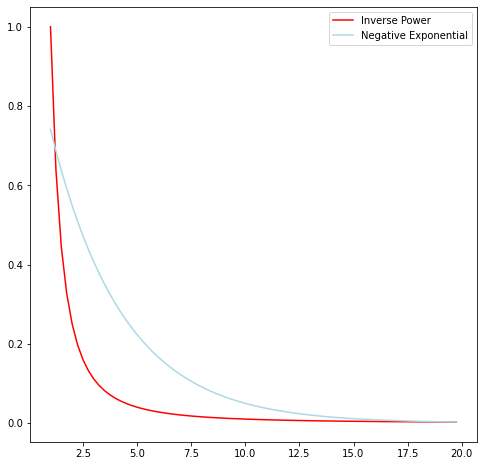

In [32]:
# Now let's consider some model tweaks.
# Starting with distance decay.
# Let's graph so distance decay parameters to get a feel for how they work.
xs = np.arange(1.0,20.0,0.25)
# inverse square power
y_inv_power = np.power(xs,-2)
# negative exponential, beta = 0.3
y_neg_exp_point3 = np.exp(-0.3*xs)

# Now a plot.
f, ax = plt.subplots(figsize=(8,8))
ax.plot(xs,y_inv_power, label = "Inverse Power", color = "red")
ax.plot(xs,y_neg_exp_point3, label = 'Negative Exponential', color = "lightblue")
ax.legend();

With these parameters, the inverse power function has a far more rapid distance decay effect than the negative exponential function. In real life, what this means is that if the observed interactions drop off very rapidly with distance, then they might be more likely to follow an inverse power law. This might be the case when looking at trips to the local convenience store by walking, for example. On the other hand, if the effect of distance is less severe (for example migration across the country for a new job) then the negative exponential funtion might be more appropriate.

There is no hard and fast rule as to which function to pick, it will just come down to which fits the data better…

As [Taylor Oshan points out in his excellent Primer](http://openjournals.wu.ac.at/region/paper_175/175.html) what this means in our Poisson regression model is that we simply substitute $-\beta \ln d_{ij}$ for $-\beta d_{ij}$ in our model:

In [33]:
# Run a production constrained SIM with a negative exponential cost function.
doubsim_form = "Total ~ Orig + Dest + Dist -1"
doubsim1 = smf.glm(formula=doubsim_form, data = cdatasub, family = sm.families.Poisson()).fit()
print(doubsim1.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  Total   No. Observations:                   42
Model:                            GLM   Df Residuals:                       28
Model Family:                 Poisson   Df Model:                           13
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1956.8
Date:                Fri, 22 Jan 2021   Deviance:                       3599.2
Time:                        11:17:53   Pearson chi2:                 3.42e+03
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Orig[Barking and Dag

In [34]:
cdatasub["doubsimfitted1"] = np.round(doubsim1.predict(),0)

In [35]:
CalcRSqaured(cdatasub["Total"],cdatasub["doubsimfitted1"])

0.9835321475412175

In [36]:
CalcRMSE(cdatasub["Total"],cdatasub["doubsimfitted1"])

423.361

So we can see that using a negative exponential in our model actually improves the fit and reduces the RMSE score.

### 4.1.2 Bunging some more variables in

Yes, the nice thing about doing all of this in a regression modelling framework is we can just keep adding rpedictor variables into the mix and seeing whether they have an effect.

You can't add origin or destination specific predictors into a doubly constrained model like this (To see why see the paper by [Flowerdew and Lovett 1988](https://onlinelibrary.wiley.com/doi/pdf/10.1111/j.1538-4632.1988.tb00184.x)) however, you could add some interaction predictors. For example, instead of modelling total flows, we could try and mdoel motorbike commuters using information on car and underground commuters:

In [37]:
KitchenSinkForm = "Motobike ~ Orig + Dest + Dist+CarDrive+Underground -1"

KitchenSinkSim = smf.glm(formula=KitchenSinkForm, data = cdatasub, family = sm.families.Poisson()).fit()
print(KitchenSinkSim.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:               Motobike   No. Observations:                   42
Model:                            GLM   Df Residuals:                       26
Model Family:                 Poisson   Df Model:                           15
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -121.73
Date:                Fri, 22 Jan 2021   Deviance:                       107.05
Time:                        11:17:53   Pearson chi2:                     89.3
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Orig[Barking and Dag

So not it gets guite interesting. Some of the dummy/constraint origins become statistically insignificant when car and tube commuters are added into the mix.

How can we interpret this?

Well, the kind of things that might influence commuting by motorbike patterns (lack of access to public transport, distance from workplace etc.) that also influence travel to work by car, aren’t applicable to centrally-located Camden with lots of public transport links. Camden is just a proxy for these factors (being centrally-located Camden with lots of public transport links), but of-course doesn’t capture the subtle variation in access to public transport and distance that car travel does. Camden’s influence is [confounded](https://en.wikipedia.org/wiki/Confounding) by these better explanatory variables and becomes insignificant.

The parameter values give an indication of exactly how much of a change in commuting flows by motorcycle you might expect either for beginning or ended in a borough or for a one person change in people travelling by Car or Tube.

If you would like some more useful ifnromation on how to interpret the parameters (logged or otherwise) that emerge from a Poisson Regression model, again, [Taylot Oshan's primer](http://openjournals.wu.ac.at/region/paper_175/175.html) is an excellent place to turn.

## From Poisson Regression back to Entropy

As with the earlier models, I have shown you how you can plug the parameter estimates back into Wilson’s entropy maximising multiplicative models in order to generate estimates and tweak things still further.

If you remember from Equations 11 and 12 above, the key to the doubly constrained models is the $A_i$ and $B_j$ balancing factors and as they rely on each other, they need to be calculated iteratively. We can do this using [Senior’s algorthim](http://journals.sagepub.com/doi/abs/10.1177/030913257900300218) also mentioned earlier.

Here is the code as provided by [Dan Lewis](https://github.com/danlewis85/UCL_CASA_Urban_Simulation/blob/master/Constrained%20SIM.ipynb) who in a departure from Dennet rewrites the algorithm as function, which can then be called subject to the required parameters. In order to this to work it requires:

- pd - a pandas dataframe of origin-destination pairwise flows and associated data.
- orig_field - the name of the dataframe field in pd that uniquely labels origin zones.
- dest_field - the name of the dataframe field in pd that uniquely labels destination zones.
- Oi_field - the name of the dataframe field that stores total flows from a given origin $i$
- Dj_field - the name of the dataframe field that stores total flows to a given destination $j$
- cij_field - the name of the dataframe field that stores the pairwise cost (e.g. distance) between $i$ and $j$
- beta - a constant for the beta parameter you wish to use in the model
- cost_function - a string representing the cost function, either 'power' or 'exponential'
- Ainame - What you want to call the new field in pd that will hold $A_{i}$ values, defaults to "Ai_new"
- Bjname - What you want to call the new field in pd that will hold $B_{j}$ values, defaults to "Bj_new"
- converge - A threshold value at which a model can be said to have converged, the default of 0.001 seems to work fine.

In [38]:

# Here is the entropy maximising approach for a known beta.
# Plug in the required values in this function to solve.

def balance_doubly_constrained(pd, orig_field, dest_field, Oi_field, Dj_field, cij_field, beta, 
                               cost_function, Ai_name = "Ai_new", Bj_name = "Bj_new", converge=0.001):
    # Define some variables
    Oi = pd[[orig_field, Oi_field]]
    Dj = pd[[dest_field,Dj_field]]    
    if cost_function.lower() in ['power','pow']:
        beta_cij = np.exp(beta * np.log(pd[cij_field]))
    elif cost_function.lower() in ['exponential','exp']:
        beta_cij = np.exp(beta * pd[cij_field])
    else:
        return "Cost function not specified properly, use 'exp' or 'pow'"
    
    # Create some helper variables
    cnvg = 1
    iteration = 0
    # Now iteratively rebalance the Ai and Bj terms until convergence
    while cnvg > converge:
        if iteration == 0:
            # This first condition sets starting values for Ai and Bj
            # NB sets starting value of Ai assuming Bj is a vector of 1s.
            # We've already established beta_cij with the appropriate cost function, so...
            Oi = Oi.assign(Ai = Dj[Dj_field] * beta_cij)
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Now set up Bjs using starting values of Ai
            Dj = Dj.assign(Bj = Oi['Ai_old'] * Oi[Oi_field] * beta_cij)
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True, suffixes = ('','_old'))
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Increment loop
            iteration += 1
        else:
            # This bit is the iterated bit of the loop which refines the values of Ai and Bj
            # First Ai
            Oi['Ai'] = Dj['Bj_old'] * Dj[Dj_field] * beta_cij
            # Aggregate Ai and take inverse
            Ai = 1.0/Oi.groupby(orig_field)['Ai'].sum().to_frame()
            # Drop temporary Ai
            Oi.drop('Ai', axis=1, inplace=True)
            # Merge new Ais 
            Oi = Oi.merge(Ai,left_on = orig_field, right_index = True)
            # Calculate the difference between old and new Ais
            Oi['diff'] = np.absolute((Oi['Ai_old'] - Oi['Ai'])/Oi['Ai_old'])
            # Set new Ais to Ai_old
            Oi['Ai_old'] = Oi['Ai']
            # Drop the temporary Ai field we created, leaving Ai_old
            Oi.drop('Ai', axis=1, inplace=True)
            
            # Then Bj
            Dj['Bj'] = Oi['Ai_old'] * Oi[Oi_field] * beta_cij
            # Aggregate Bj and take inverse
            Bj = 1.0/Dj.groupby(dest_field)['Bj'].sum().to_frame()
            # Drop temporary Bj
            Dj.drop('Bj', axis=1, inplace=True)
            # Merge new Bjs
            Dj = Dj.merge(Bj,left_on = dest_field, right_index = True)
            # Calculate the difference between old and new Bjs
            Dj['diff'] = np.absolute((Dj['Bj_old'] - Dj['Bj'])/Dj['Bj_old'])
            # Set new Bjs to Bj_old
            Dj['Bj_old'] = Dj['Bj']
            # Drop the temporary Bj field we created, leaving Bj_old
            Dj.drop('Bj', axis=1, inplace=True)
            
            # Assign higher sum difference from Ai or Bj to cnvg
            cnvg = np.maximum(Oi['diff'].sum(),Dj['diff'].sum())
            
            # Print and increment loop
            print("Iteration:", iteration)
            iteration += 1

    # When the while loop finishes add the computed Ai_old and Bj_old to the dataframe and return
    pd[Ai_name] = Oi['Ai_old']
    pd[Bj_name] = Dj['Bj_old']
    return pd


Using the function above we can calculate $A_{i}$ and $B_{j}$ for the previous Poisson model by plugging in the estimate of beta that we generated.

In [39]:

# Use the beta we got from the inverse power model
beta = doubSim.params[-1]
# Get the balancing factors.
cdatasub = balance_doubly_constrained(cdatasub,'OrigCodeNew','DestCodeNew','O_i','D_j','Dist',beta,'power')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_pow'] = np.round(cdatasub['O_i'] * cdatasub['Ai_new'] * cdatasub['D_j'] * cdatasub['Bj_new'] * 
                                   np.exp(np.log(cdatasub['Dist'])*beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_pow',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8


Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0,309,849,135,420,969,2993,5675.0
Barnet,23,0,72,5533,194,12970,6669,25461.0
Bexley,500,561,0,303,4454,1991,6877,14686.0
Brent,10,5275,37,0,125,8885,4176,18508.0
Bromley,134,818,2406,553,0,3127,10294,17332.0
Camden,6,1140,22,819,65,0,9716,11768.0
City of London,1,20,3,13,7,328,0,372.0
All,674,8123,3389,7356,5265,28270,40725,93802.0


In [40]:
# Use the beta we got from the negative exponential model
beta = doubsim1.params[-1]
# Get the balancing factors. NB Setting of new field names for Ai and Bj.
cdatasub = balance_doubly_constrained(cdatasub,'OrigCodeNew','DestCodeNew','O_i','D_j','Dist',beta,'exponential','Ai_exp','Bj_exp')

# Now predict the model again using the new Ai and Dj fields.
cdatasub['SIM_est_exp'] = np.round(cdatasub['O_i'] * cdatasub['Ai_exp'] * cdatasub['D_j'] * cdatasub['Bj_exp'] * 
                                   np.exp(cdatasub['Dist']*beta))
# Check out the matrix
pd.pivot_table(cdatasub,values='SIM_est_exp',index ='Orig',columns='Dest',fill_value=0,aggfunc=sum,margins=True)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


Dest,Barking and Dagenham,Barnet,Bexley,Brent,Bromley,Camden,City of London,All
Orig,,,,,,,,
Barking and Dagenham,0,261,713,98,387,1110,3106,5675.0
Barnet,17,0,31,5274,66,13108,6966,25462.0
Bexley,490,324,0,178,4664,1986,7043,14685.0
Brent,6,5052,16,0,57,8719,4658,18508.0
Bromley,148,392,2597,353,0,3057,10784,17331.0
Camden,11,2054,29,1426,81,0,8168,11769.0
City of London,1,39,4,27,10,290,0,371.0
All,673,8122,3390,7356,5265,28270,40725,93801.0


## 5. Conclusions, further notes and ideas for additional activities
Hopefully you have now seen how it is extremely straight-forward to run and calibrate Wilson’s full family of Spatial Interaction Models in R using GLM and Poisson Regression.

### 5.1 Some Further Notes
Now might be the time to mention that despite everything I’ve shown you, there has been some discussion in the literature as to whether the Poisson Model is actually a misspecification, especially for modelling migration flows. If you have the stomach for it, [this paper by Congdon goes into a lot of detail.](http://journals.sagepub.com/doi/abs/10.1068/a251481)

The issue is a thing called ‘overdispersion’ which, translated, essentially relates to the model not being able to capture all of the things that could be explaining the flows in the independent variables that are supplied to the model. The details are tedious and only really intelligible to those with a statistics background. If you want a starter, [try here](https://en.wikipedia.org/wiki/Overdispersion), but in practical terms, we can get around this problem by fitting a very similar sort of regression model called the negative binomial regression model.

If you wish, you can read up and experiment with this model - you can fit it in exactly the same way as the poisson glm model but using: family = sm.families.NegativeBinomial(alpha) when you call the statsmodel glm function. The negative binomial model has an extra parameter - alpha - in the model for overdispersion with a default of 1. If you do try this, you will almost certainly discover that your results barely change - but hell, you might keep a pedantic reviewer at bay if you submit this to a journal (not that I’m speaking from experience or anything).

### And some more comments

Another thing to note is that the example we used here had quite neat data. You will almost certainly run into problems if you have sparse data or predictors with 0s in them. If this happens, then you might need to either drop some rows in your data (if populated with 0s) or substitute 0s for very small numbers, much less than 1, but greater than 0 (this is because you can’t take the log of 0). [Taylor Oshan's SpInt](http://openjournals.wu.ac.at/region/paper_175/175.html) implementation in Python uses a special Poisson regression approach that better handles sparse data structures.

And another thing to note is that our flow data and our predictors were all in and around the same order or magnitude. If you suddenly get data that (such as population masses at origins and destinations) that are an order of magnitude different (i.e. populations about ten times larger in different locations) then the model estimates might be biased. Fortunately, there are packages available to help us with these problems as well.

### 5.2 Further Activities
1. Testing these models out on the whole of London and for different years
    - You’ve been playing around with just a small 7 borough sample, why not try the full London system. +You can also try and download some similar data from the 2011 Census from [Wicid](http://wicid.ukdataservice.ac.uk/) - see if using Oi and Dj totals and the parameters you calibrated on the 2001 data, whether you can get reasonable estimates of the 2011 flows. +How have the model parameters changed between 2001 and 2011 - what does this mean
2. Visualising your flow estimates
    - try using the methods  last practical to visualise some of your flow estimates or flow residuals…